## This notebook provides a set of examples on how to use the numerical method for the overscreening breakdown problem.

#### The equations under consideration in a general form are:
$$
u_{xx} - \delta^2 u_{xxxx} = f(u, x), x\in[0, \infty)
$$

#### where the right hand side function for the overscreening breakdown problem is formulated as:

$$
f(u,x) :=  \frac{\sinh(u)}{1 +2\gamma \sinh^2\left(u/2\right)} - \frac{0.5 \Phi(x) e^{u}}{1 +2\gamma \sinh^2\left(u/2\right)},
$$


$$
\Phi(x) = \mu \frac{1}{\sqrt{2 \pi}} \exp{\left(-\frac{x^2}{2(\sigma/L_D)^2}\right)}
$$

In [1]:
#load modules

from matplotlib import pyplot as plt
import numpy as np
from spectral1d import solve_nonlinear_problem # needed module
from overscreening_breakdown import overscreening_breakdown #needed module
%matplotlib inline

In [2]:
#init the problem

problem = overscreening_breakdown()

In [3]:
#set up the solver by providing numerical parameters.

N = 100
domain = [0,np.inf]
tolerance = 1.0e-10
use_method = "newton"
use_adjoint_opimization = False
L = 6 #on the sellection of this parameter, see bellow 
solver = solve_nonlinear_problem(N=N, domain=domain, tolerance=tolerance, use_method=use_method, use_adjoint_opimization = use_adjoint_opimization)
solver.set_mapping_parameter(L)

### On how to select the parameter $L$, see [bellow](#check_L_values).
But we recommend exploring all cells to be certain on what you are doing.

In [4]:
#set up the problem.
#If a parameter is not given, then a default value is used instead. 
#See the source file of "overscreening_breakdown" for more details for defauls values

sigma = 20.0
mu = 0.36
gamma = 1
delta = 10.0
u0 = 1.0
u0xxx = 0

#use some function as initial guess for the root in the Newton's method.
def some_func(x):
    return u0*np.exp(-x)

#apply parameters
problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [5]:
#pass the problem to the solver

solver.set_problem(problem)

In [6]:
# solve the problem

c = solver.solve_problem()

newton: relative target tolerance = 1.009950e-09
newton: iteration  1 , residual norm 1.067226e-04 , weight = 1.000000e+00
newton: iteration  2 , residual norm 4.360966e-08 , weight = 1.000000e+00
newton: iteration  3 , residual norm 6.084760e-14 , weight = 1.000000e+00
converged with norm = 6.084760e-14


In [7]:
# solve the problem with adjoint optimization root preconditioning for the Newton's method.
# Note, that this variable can also be passed to the constructor
use_adjoint_opimization = True
solver.reset_base_solution() #resetting base solution to make sure we compute a new one
solver.use_adjoint_opimization(use_adjoint_opimization)
c_ao = solver.solve_problem()

Using initial guess update by the adjoint optimization.
newton: relative target tolerance = 1.009950e-09
newton: iteration  1 , residual norm 6.330256e-11 , weight = 1.000000e+00
converged with norm = 6.330256e-11


In [8]:
#check solution relative difference
np.linalg.norm(c_ao - c)/np.linalg.norm(c)

6.23119658138063e-09

In [9]:
#optionally save and load a solution for further use
#solution is stored in expension coefficients

solver.save_solution("solution.pickle", c) #saving solution to file "solution.pickle"
c1 = solver.load_data("solution.pickle") #loading solution from file "solution.pickle" to a variable c1
print("checking difference in saved data: ", np.linalg.norm(c-c1)) #testing, that everything is ok

checking difference in saved data:  0.0


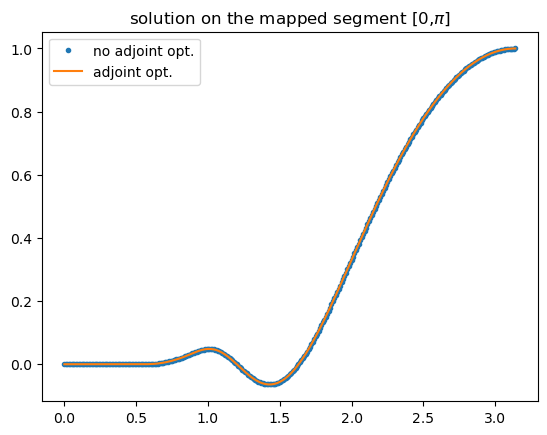

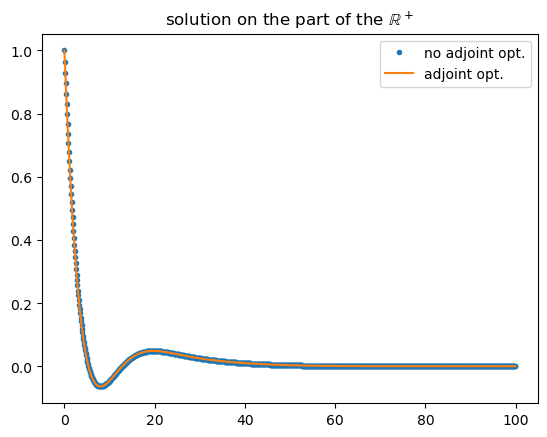

In [10]:
#plotting the solution in different domains

#plotting in computational domain in [0, $pi$]
t = np.arange(0, np.pi, 0.01) 
sol = solver.obtain_solution_in_basis(c, t)
sol_ao = solver.obtain_solution_in_basis(c_ao, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol,'.')
plt.plot(t, sol_ao)
plt.legend(["no adjoint opt.","adjoint opt."])
plt.show()

#plotting in physical domain for 0<=x<=100
x = np.arange(0.0, 100.0, 0.1)
sol = solver.obtain_solution_in_domain(c, x)
sol_ao = solver.obtain_solution_in_domain(c_ao, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol, '.')
plt.plot(x, sol_ao)
plt.legend(["no adjoint opt.","adjoint opt."])
plt.show()

Next we demonstrate the applicaiton of the size globalization for a very stiff problem using globalization in the size of the problem thanks to the natural behaviour of spectral methods.

In [ ]:
#we are setting initial parameters to the problem for this test, specially desiged to be very stiff
sigma = 10.0
mu = 1
gamma = 1/2
delta = 50.0
u0 = 100.0
u0xxx = 0

#initial guess should be u0*np.exp(-x**2). This breaks the problem convergence
def some_func(x):
    return np.exp(-x**2) 

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
# normal size problem fails to converge due to very stiff nonlinearity (artificially made)

N = 100
solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 20, use_globalization = False, use_adjoint_opimization = use_adjoint_opimization)
solver.set_mapping_parameter(L)
solver.set_problem(problem)
c = solver.solve_problem()

In [ ]:
# We may try to use mpmath library with a variable custom floating point precision to find a solution.
# this may take some time since mpmath is very slow in python.
#in this case the function should have a mpmath operation, so the problem is reinitialized
import mpmath as mp
print("using data:")
print("u0 =", u0)

#the same defect in the initial funciton
def some_func_mp(x):
    vexp = np.vectorize(mp.exp)
    return vexp(-x**2) 

problem_mp = overscreening_breakdown()
problem_mp.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func_mp)


N = 100
use_mpmath = True
prec = 120 # sets up number of significant digits, default is 100
tolerance_mp = 1.0e-30 #can achieve very high precision which is limited only by the resources of a computer

solver_mp = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance_mp, use_method=use_method, total_iterations = 20, use_globalization = False, use_adjoint_opimization = use_adjoint_opimization, use_mpmath = use_mpmath, prec = prec)
solver_mp.set_mapping_parameter(L)
solver_mp.set_problem(problem_mp)
c_mp = solver_mp.solve_problem()

In [ ]:
#and check final high precision solutions
t = np.arange(0, np.pi, 0.01)
x = np.arange(0, 100, 0.1)
sol = solver_mp.obtain_solution_in_basis(c_mp, t)
sol_x = solver_mp.obtain_solution_in_domain(c_mp, x)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol_x)
plt.show()


In [ ]:
# now we perfrom a set of iterations to update a better initial guess from the smaller problem size
N_base = 10
N = N_base # starting solutins from N_base and then increasing the resolution gradually
c1 = None
it = 2
while it < 12:
    print("running on N = ", N)
    solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 20, use_globalization = False)
    solver.set_mapping_parameter(L)
    solver.set_problem(problem)
    c = solver.solve_problem(c1)
    if solver.is_converged():
        c1 = np.copy(c)
        N = N_base*it
        it = it + 1
    else:
        N = N - 5
        

In [ ]:
#and check 2 final consecutive solutions 
t = np.arange(0, np.pi, 0.01)
x = np.arange(0, 60, 0.1)
sol1 = solver.obtain_solution_in_basis(c1, t)
sol = solver.obtain_solution_in_basis(c, t)
sol_mp = solver_mp.obtain_solution_in_basis(c_mp, t)
sol1_x = solver.obtain_solution_in_domain(c1, x)
sol_x = solver.obtain_solution_in_domain(c, x)
sol_mp_x = solver_mp.obtain_solution_in_domain(c_mp, x)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol_mp, 'o')
plt.plot(t, sol1, '.')
plt.plot(t, sol)
plt.legend(["high precision solution","size {:d}".format(N-20), "size {:d}".format(N-10)])
plt.show()
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol_mp_x, 'o')
plt.plot(x, sol1_x, '.')
plt.plot(x, sol_x)
plt.legend(["high precision solution","size {:d}".format(N-20), "size {:d}".format(N-10)])
plt.show()

Next we demonstrate the applicaiton of the homotopy* globalization for the same stiff problem.

*https://en.wikipedia.org/wiki/Homotopy

In [ ]:
solver = solve_nonlinear_problem(N=100, domain=[0,np.inf], tolerance=tolerance, use_method="newton", total_iterations = 20, use_globalization = True, use_adjoint_opimization = use_adjoint_opimization)
solver.set_mapping_parameter(L)
solver.set_problem(problem)

In [ ]:
c2 = solver.solve_problem()

In [ ]:
#and demonstrate the converged solution compared with the previous one
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c1, t)
sol2 = solver.obtain_solution_in_basis(c2, t)
plt.title("compare two solutions on the mapped segment [0,$\pi$]")
plt.plot(t, sol2,'.')
plt.plot(t, sol)
plt.show()
plt.title("error between two solutions (obtained from size and homotopy globalizations) on the mapped segment [0, $\pi$]")
plt.plot(t, sol-sol2)
plt.show()

<a id='check_L_values'></a>
## Here we demonstrate how to find a stable value of the mapping parameter L for the given problem.

One should choose the smallest possible value of L at which the solutions are stable w.r.t. the discretization


In [ ]:
#setup desired problem parameters for the test

sigma = 10.0
mu = 1
gamma = 1/2
delta = 10.0
u0 = 1.0
u0xxx = 0

#solution initial guess
def some_func(x):
    return u0*np.exp(-x) 

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
#setup different sizes to be checked, so we can select the value of 'L' independent on the parameter value
Nall = [30,70,80,100] 
Lall = [1,2,3,4,5,6] #setup different values of the parameter 'L' to be checked
t = np.arange(0, np.pi, 0.01)
x = np.arange(0, 100, 0.1)
use_adjoint_opimization = True
for L in Lall:
    c_dict = {}
    c1 = None
    for N in Nall:
        solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method="newton", total_iterations = 20, use_globalization = False)
        solver.set_mapping_parameter(L)
        solver.set_problem(problem)
        c = solver.solve_problem(c1)
        c_dict[N] = c
        c1 = np.copy(c)
    for N in Nall:
        c_l = c_dict[N]
        sol = solver.obtain_solution_in_basis(c_l, t)
        plt.plot(t, sol, label=N)
        
    plt.legend()
    plt.title("segement, L = " + str(L))
    plt.show()
    
    for N in Nall:
        c_l = c_dict[N]
        sol = solver.obtain_solution_in_domain(c_l, x)
        plt.plot(x, sol, label=N)
        
    plt.legend()
    plt.title("$\mathbb{R}^+$, L = " + str(L))
    plt.show()    
    
print("For this problem it is recomended to use L=5 or L=6.")

In the section bellow we demonstrate how to solve the Poisson problem in the form:
$$
u_{xx}=f(x,u), x\in[0, \infty)
$$

In [ ]:
#setup parameters for the problem

sigma = 1.0
mu = 1
gamma = 1
delta = 0.0  # remove the 4-th order derivative
u0 = 1.0     
u0xxx = None # remove the third derivative boundary condition

#initial guess for the solutions
def some_func(x):
    return u0*np.exp(-x)

#init problem class
problem = overscreening_breakdown()
#set parameters
problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)
#pass the problem to the solver
solver.set_problem(problem)
# solve the problem
c = solver.solve_problem()

#see the solution
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
x = np.arange(0.0, 10.0, 0.1)
sol = solver.obtain_solution_in_domain(c, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol)
plt.show()

### Bellow some additional tests are provided.

Feel free to test your parameters as well.

In [ ]:
#set up problem.
#If a parameter is not given, then a default value is used instead. See the source file of "overscreening_breakdown" for more details

sigma = 20.0
mu = 0.0
gamma = 0.1
delta = 0.0
u0 = 0.1
u0xxx = 0

def some_func(x):
    return u0*np.exp(-x**4)

problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)

In [ ]:
solver.set_problem(problem)
c = solver.solve_problem()
#see the solution
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
x = np.arange(0.0, 40.0, 0.1)
sol = solver.obtain_solution_in_domain(c, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol)
plt.show()

In [ ]:
# we perfrom a set of iterations to update a better initial guess from the smaller problem size
def some_func(x):
    return u0*np.exp(-x**4)

L = 1
tolerance = 1.0e-10
N = 60
sigma = 20.0
mu = 0.0
gamma = 1.0
delta = 0.0
u0 = 10.0
u0xxx = 0
u0_c = 0.1
c1 = None
alpha = 1.0

def some_func(x):
    return 2*np.log((1.0+np.tanh(u0/4.0)*np.exp(-x))/(1.0-np.tanh(u0/4.0)*np.exp(-x)))

for it in range(1,1000):
    print("running on gamma = ", gamma)
    solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 100, use_globalization = False)
    solver.set_mapping_parameter(L)
    problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)
    solver.set_problem(problem)
    c = solver.solve_problem(c1)
    if solver.is_converged():
        c1 = np.copy(c)
        gamma_old = gamma
        gamma = gamma*0.5
        gamma_found = gamma;
        alpha = 1.0
    else:
        alpha = alpha*0.5
        gamma = (1-alpha)*gamma_old + alpha*gamma_found
    if gamma == 0.0:
        break
    if gamma<1.0e-12:
        gamma = 0.0

In [ ]:
# we apply homotopy when solution fails to converge for some bad RHS
def some_func(x):
    return u0*np.exp(-x**2)
L = 1
tolerance = 1.0e-10
N = 100
sigma = 20.0
mu = 0.0
gamma = 0.0

delta = 0.0
u0 = 2.0
u0xxx = 0
def some_func(x):
    return 2*np.log((1.0+np.tanh(u0/4.0)*np.exp(-x))/(1.0-np.tanh(u0/4.0)*np.exp(-x)))

solver = solve_nonlinear_problem(N=N, domain=[0,np.inf], tolerance=tolerance, use_method=use_method, total_iterations = 10, use_globalization = True)
solver.set_mapping_parameter(L)
problem.set_parameters(sigma = sigma, mu = mu, gamma = gamma, delta = delta, u0 = u0, u0xxx=u0xxx, initial_guess_solution=some_func)
solver.set_problem(problem)
c = solver.solve_problem()

In [ ]:
#see the solution
t = np.arange(0, np.pi, 0.01)
sol = solver.obtain_solution_in_basis(c, t)
plt.title("solution on the mapped segment [0,$\pi$]")
plt.plot(t, sol)
plt.show()
x = np.arange(0.0, 5.0, 0.01)
sol = solver.obtain_solution_in_domain(c, x)
plt.title("solution on the part of the $\mathbb{R}^+$")
plt.plot(x, sol)
plt.show()